In [1]:
import math
from os import listdir
from itertools import product
from collections import Counter
import pickle 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
import numpy as np
from tqdm import tqdm

from scipy.stats import ks_2samp

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, rdMolDescriptors, MolFromSmiles, MolToSmiles, Draw, MolFromMolFile
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

from rdkit.Chem import ChemicalFeatures
from rdkit import Geometry
from rdkit.Chem.rdmolfiles import MolFromPDBBlock, MolFromPDBFile
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.RDPaths import RDDataDir
import os.path

fdefFile = os.path.join(RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefFile)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # removes annoying RDKit warnings

import py3Dmol
import mols2grid

from rdkit.Chem.SaltRemover import SaltRemover
remover = SaltRemover()

# import frag_funcs
# import importlib
# importlib.reload(frag_funcs)

from ipywidgets import interact


INFO:rdkit:Enabling RDKit 2022.03.2 jupyter extensions


# Data Reading

In [4]:
data_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/Mac1'

df_sites = pd.read_csv(data_dir + '/hits_ids.csv')

print('Length of df_sites :{}'.format(len(df_sites)))

# 15/06/2021
# A1 - Adenine site (XChem) = 15
# A2 - Adenine site (UCSF) = 0, 10

sites = [0, 10, 15]

df_sites = df_sites[df_sites['site_number'].isin(sites)]

print('Length of new df_sites :{}'.format(len(df_sites)))

smiles_list = []

for i,row in tqdm(df_sites.iterrows(), total=len(df_sites)):
    try:
        crystal_id = row['crystal_id'].split(':')[0]
#         print(crystal_id)
        smiles_path =  data_dir + '/aligned/'+crystal_id+'/'+crystal_id+'_smiles.txt'
        f = open(smiles_path, "r")
        smiles = f.read()

        smiles_list.append(MolToSmiles(MolFromSmiles(smiles)))
    except Exception as ex:
        print("Couldn't generate conformers for {}".format(smiles))
        print(ex)

print('Number of smiles: {}'.format(len(smiles_list)))
print('Number of unique smiles: {}'.format(len(set(smiles_list))))

Length of df_sites :279
Length of new df_sites :151


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 151/151 [00:02<00:00, 69.60it/s]

Number of smiles: 151
Number of unique smiles: 133


In [5]:
data_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/Mac1'

df_sites = pd.read_csv(data_dir + '/hits_ids.csv')

print('Length of df_sites :{}'.format(len(df_sites)))

# 15/06/2021
# A1 - Adenine site (XChem) = 15
# A2 - Adenine site (UCSF) = 0, 10

sites = [0, 10, 15]

df_sites = df_sites[df_sites['site_number'].isin(sites)]

print('Length of new df_sites :{}'.format(len(df_sites)))

frags = []
smiles_list = []

ids = []
for i,row in tqdm(df_sites.iterrows(), total=len(df_sites)):
    try:
        crystal_id = row['crystal_id'].split(':')[0]
#         print(crystal_id)
        smiles_path =  data_dir + '/aligned/'+crystal_id+'/'+crystal_id+'_smiles.txt'
        f = open(smiles_path, "r")
        smiles = f.read()

        mol_path = data_dir + '/aligned/'+crystal_id+'/'+crystal_id+'.mol'
        mol = MolFromMolFile(mol_path)    
        conf = mol.GetConformer()

        ligand_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            ligand_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]])

        frags.append(ligand_data)
        ids.append(crystal_id)
        smiles_list.append(MolToSmiles(MolFromSmiles(smiles)))
    except Exception as ex:
        print("Couldn't generate conformers for {}".format(smiles))
        print(ex)

Length of df_sites :279
Length of new df_sites :151


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 151/151 [00:02<00:00, 65.20it/s]


# Sanity check plotting

In [6]:
mols = []

for frag in frags:
    tmp = frag[0]
    tmp = Chem.RemoveHs(tmp)
    AllChem.Compute2DCoords(tmp)
    mols.append(tmp)

print('Number of noncovalent binding frags: {}'.format(len(mols)))

mol_df = pd.DataFrame({"mol": mols,
                   "name": ids})
mols2grid.display(mol_df, mol_col='mol', subset=['img', 'name'], tooltip=['name'], selection=True, n_cols=6, n_rows=6)

Number of noncovalent binding frags: 151


In [7]:
# Mac1-UCSF-P0590_0A looks weird (index 138) - two sets of coordinates recorded, deleted just in case

frags_save = [frag for i,frag in enumerate(frags) if i!=138]
ids = [id for i,id in enumerate(ids) if i!=138]
smiles_list = [smi for i, smi in enumerate(smiles_list) if i!=138]

counts = Counter(smiles_list)
# print(counts)
weights = [1/counts[smi] for smi in smiles_list]
print(weights)
print(len(weights))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 1.0, 1.0, 0.5, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.5, 1.0, 1.0]
150


In [8]:
print(sum(weights))

132.0


In [6]:
view = py3Dmol.view()
# Mac1-UCSF-P0590_0A looks weird (index 138) - two sets of coordinates recorded, deleted just in case
# frags = [frag for i,frag in enumerate(frags) if i!=138]
# ids = [id for i,id in enumerate(ids) if i!=138]
# with open(data_dir + '/frags.pickle', 'wb') as pickle_file:
#     pickle.dump(frags, pickle_file)
file = open(data_dir+'/aligned/Mac1-DLS-X0967_0A/Mac1-DLS-X0967_0A_apo-desolv.pdb','r')
mac = file.read()

for mol in frags_save:
# for mol in frags[138:139]:
    mb = Chem.MolToMolBlock(Chem.RemoveHs(mol[0]), confId=-1)
    view.addModel(mb, 'sdf')
view.setStyle({'stick': {}})
view.addModel(mac, 'pdb')
view.setStyle({'model': -1},{'cartoon':{}})
view.setBackgroundColor('0xffffff')
view.zoomTo()
view

data_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/Mac1'
pickle.dump(frags_save, open(data_dir + '/frags_mac1.pickle', 'wb'))
pickle.dump(weights, open(data_dir + '/weights_mac1.pickle', 'wb'))


In [ ]:
from frag_funcs import return_pcore_dataframe
view = py3Dmol.view()

file = open(data_dir+'/aligned/Mac1-DLS-X0967_0A/Mac1-DLS-X0967_0A_apo-desolv.pdb','r')
mpro = file.read()
view.addModel(mpro, 'pdb')
view.setStyle({'model': -1},{'cartoon':{}})
interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

colors = {'Donor': 'O','Acceptor': 'N','Aromatic':'Cl'}

frag_df = return_pcore_dataframe(frags, interesting_pcores)

frag_df = frag_df[['pcore','coord_x','coord_y','coord_z']]
frag_df['pcore'] = [colors[x] for x in frag_df['pcore']]
frag_df['coord_x'] = frag_df['coord_x'].astype(str)
frag_df['coord_y'] = frag_df['coord_y'].astype(str)
frag_df['coord_z'] = frag_df['coord_z'].astype(str)

# print(frag_df.head())
def plot_3d(r):
    frag_pcores=str(len(frag_df))+'\n\n'
    vol_data = []
    for i, row in frag_df.iterrows():
        vol_data.append(row['pcore']+' '+row['coord_x']+' '+row['coord_y']+' '+row['coord_z'])
        frag_pcores = frag_pcores + row['pcore']+' '+row['coord_x']+' '+row['coord_y']+' '+row['coord_z']+'\n'
    view.addModel(frag_pcores, 'xyz')
    view.setStyle({'model': -1},{'sphere': {'radius':r, 'opacity':0.75}})
    view.setBackgroundColor('0xffffff')
#     view.addSurface(py3Dmol.MS, {'opacity': 1.0})    
    view.zoomTo()
    view.show()

from ipywidgets import interact

interact(plot_3d, r=(0.1,1.0,0.1)); # (min, max, step)

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 150/150 [00:01<00:00, 92.63it/s]


interactive(children=(FloatSlider(value=0.5, description='r', max=1.0, min=0.1), Output()), _dom_classes=('widâ€¦

In [ ]:
# from .. import frag_funcs
import frag_funcs
# from frag_funcs import return_random_dataframe, return_pcore_dataframe, get_pair_distances, fit_pair_kde
# import importlib
# importlib.reload(frag_funcs)

<module 'frag_funcs' from '/home/wjm41/ml_physics/frag-pcore-screen/notebooks/frag_funcs.py'>

In [7]:
n_rand = 10

frag_pair_distance_dict = {} 
frag_weight_dict = {}

# real_pair_dicts = [{} for i in range(n_rand)]  
rand_pair_dicts = [{} for i in range(n_rand)]  

interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

fragpcore_df = frag_funcs.return_pcore_dataframe(
    frags_save, interesting_pcores, weights=weights)
# fragpcore_dfs = [return_pcore_dataframe(frags, interesting_pcores, jiggle=True) for i in range(n_rand)]
# rand_dfs = [frag_funcs.return_random_dataframe(frags, interesting_pcores) for i in range(n_rand)]

for pcore_pair in tqdm(product(interesting_pcores,repeat=2)):
    core_a,core_b = pcore_pair
    combo = core_a+'-'+core_b
    twobody_hists, twobody_weights = frag_funcs.get_pair_distances(fragpcore_df, core_a, core_b, frag=True)
    frag_pair_distance_dict[combo] = np.hstack(twobody_hists)
    frag_weight_dict[combo] = np.hstack(twobody_weights)
#     for i,fragpcore_df in enumerate(fragpcore_dfs):
#         real_pair_dicts[i][combo] = np.hstack(get_pair_distances(fragpcore_df, core_a, core_b, frag=True))
        
    # for i,rand_df in enumerate(rand_dfs):
        # rand_pair_dicts[i][combo] = np.hstack(frag_funcs.get_pair_distances(rand_df, core_a, core_b, frag=True))

pickle_dir = '/home/wjm41/ml_physics/frag-pcore-screen/notebooks/pickles'
pickle.dump(frag_pair_distance_dict, open(pickle_dir + '/frag_pair_distance_dict_mac1.pickle', 'wb'))
pickle.dump(frag_weight_dict, open(pickle_dir + '/frag_weight_dict_mac1.pickle', 'wb'))

# pickle.dump(rand_pair_dicts, open('rand_pair_dicts.pickle', 'wb'))


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 150/150 [00:01<00:00, 93.50it/s]
9it [00:09,  1.06s/it]


In [ ]:
combo_list = []

kde_dict = {}
# real_kde_dicts = [{} for i in range(n_rand)]
rand_kde_dicts = [{} for i in range(n_rand)]

pairs = ['Donor-Aromatic',
        'Aromatic-Acceptor',
        'Aromatic-Aromatic',
        'Donor-Donor',
        'Donor-Acceptor',
        'Acceptor-Acceptor']

kde_dict_opt = {}
for combo in tqdm(pairs):
    kde_dict_opt[combo] = frag_funcs.fit_pair_kde(frag_pair_distance_dict[combo], l=1, n=10)
    for i in range(n_rand):
#         real_kde_dicts[i][combo] = fit_pair_kde(real_pair_dicts[i][combo])
        rand_kde_dicts[i][combo] = frag_funcs.fit_pair_kde(rand_pair_dicts[i][combo], l=1, n=10)    
    
pickle.dump(kde_dict_opt, open('kde_dict_opt_mac.pickle', 'wb'))    
pickle.dump(rand_kde_dicts, open('rand_kde_dicts_mac.pickle', 'wb'))  



In [3]:
data_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/Mac1'

notebook_dir = '/home/wjm41/ml_physics/frag-pcore-screen/notebooks'

frags = pickle.load(open(data_dir + '/frags.pickle', 'rb'))
frag_pair_distance_dict = pickle.load(open(notebook_dir + '/frag_pair_distance_dict.pickle', 'rb'))
rand_pair_dicts = pickle.load(open(notebook_dir + '/rand_pair_dicts.pickle', 'rb'))

# kde_dict_opt = pickle.load(open(notebook_dir + '/kde_dict_opt_mac.pickle', 'rb'))
# rand_kde_dicts = pickle.load(open(notebook_dir + '/rand_kde_dicts_mac.pickle', 'rb'))

pairs = ['Donor-Aromatic',
        'Aromatic-Acceptor',
        'Aromatic-Aromatic',
        'Donor-Donor',
        'Donor-Acceptor',
        'Acceptor-Acceptor']

kde_dict_opt = pickle.load(open(notebook_dir + '/kde_dict_opt'+pairs[0]+'.pickle', 'rb'))
rand_kde_dicts = pickle.load(open(notebook_dir + '/rand_kde_dicts'+pairs[0]+'.pickle', 'rb'))

n_rand=50
for pair in pairs[1:]:
    kde_dict_opt.update(pickle.load(open(notebook_dir + '/kde_dict_opt'+pair+'.pickle', 'rb')))
    rand_dicts = pickle.load(open(notebook_dir + '/rand_kde_dicts'+pair+'.pickle', 'rb'))
    for n in range(n_rand):
        rand_kde_dicts[n].update(rand_dicts[n])
        
pickle.dump(kde_dict_opt, open('kde_dict_opt_mac.pickle', 'wb'))    
pickle.dump(rand_kde_dicts, open('rand_kde_dicts_mac.pickle', 'wb'))  

# p-values

### Raw Distribution truncated to same length

In [ ]:
import math 
from scipy.stats import ks_2samp

def rounddown(x):
    return int(math.floor(x / 10.0)) * 10

pval_median = []
pval_std = []
pvals = []
n_list = []

combo_list = []
n_rand = 10

for i, combo in tqdm(enumerate(pairs), total=6):
    combo_list.append(combo)
    real = frag_pair_distance_dict[combo]

    pval_list = []
    for n in range(n_rand):
        rand = rand_pair_dicts[n][combo]
        n1 = len(real)
        n2 = len(rand)
        N = rounddown(min(n1,n2))
        pval_list.append(ks_2samp(np.random.choice(real,N, replace=False), np.random.choice(rand,N, replace=False), mode='exact')[1]) # doesn't work cuz can't weight
        
    pvals.append(pval_list)
    pval_median.append(np.median(pval_list))
    pval_std.append(np.std(pval_list)) 
    n_list.append(n1)
#     raise Exception
    
pval_df = pd.DataFrame(list(zip(combo_list, pval_median, pval_std, n_list)), 
                         columns = ['combo','p-value median', 'p-value std', 'N'])
print('Raw')
print(pval_df)

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 6/6 [00:02<00:00,  2.22it/s]

Raw
               combo  p-value median   p-value std       N
0     Donor-Aromatic   2.961347e-123  1.124910e-24   54798
1  Aromatic-Acceptor    1.953402e-86  2.495815e-46   72979
2  Aromatic-Aromatic   9.881313e-324  0.000000e+00   44998
3        Donor-Donor    1.427767e-31  7.267897e-10   66492
4     Donor-Acceptor   1.753208e-291  0.000000e+00   88748
5  Acceptor-Acceptor   1.976263e-323  0.000000e+00  118040


### KDEs scored on original distribution

In [ ]:
from scipy.stats import ks_2samp

combo_list = []

pvals = []
pval_median = []
pval_iqr = []

nx = 500
# n_rand = 10
n_rand = 50


pairs = ['Donor-Aromatic',
        'Aromatic-Acceptor',
        'Aromatic-Aromatic',
        'Donor-Donor',
        'Donor-Acceptor',
        'Acceptor-Acceptor']

for combo in tqdm(pairs):
    combo_list.append(combo)
    
    kde_pair = kde_dict_opt[combo]
    x = frag_pair_distance_dict[combo]
    
    pair_dist = np.exp(kde_pair.score_samples(x.reshape(-1,1)))
    pair_dist = pair_dist.flatten()
    
    pval_list = []
    
    rand_dists = []
    for i in range(n_rand):

        kde_rand = rand_kde_dicts[i][combo]

        rand_dist = np.exp(kde_rand.score_samples(x.reshape(-1,1)))

        rand_dist = rand_dist.flatten()
    
        rand_dists.append(rand_dist)
        pval_list.append(ks_2samp(pair_dist, rand_dist)[1])

    pval_median.append(np.median(pval_list))
    pval_iqr.append(np.subtract(*np.percentile(pval_list, [75, 25])))


    pvals.append(pval_list)
    

pval_df = pd.DataFrame(list(zip(combo_list, pval_median, pval_iqr)), 
                         columns = ['combo','p-value median', 'p-value iqr'])
print(pval_df)

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 6/6 [4:44:26<00:00, 2844.37s/it]


               combo  p-value median  p-value iqr
0     Donor-Aromatic             0.0          0.0
1  Aromatic-Acceptor             0.0          0.0
2  Aromatic-Aromatic             0.0          0.0
3        Donor-Donor             0.0          0.0
4     Donor-Acceptor             0.0          0.0
5  Acceptor-Acceptor             0.0          0.0


In [ ]:
print(pval_median)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### KDE uniformly sampled

In [ ]:
from scipy.stats import ks_2samp

combo_list = []

pvals = []
pval_median = []
pval_iqr = []

# n_rand = 10
n_rand = 50


pairs = ['Donor-Aromatic',
        'Aromatic-Acceptor',
        'Aromatic-Aromatic',
        'Donor-Donor',
        'Donor-Acceptor',
        'Acceptor-Acceptor']

for combo in pairs:
    combo_list.append(combo)
    
    kde_pair = kde_dict_opt[combo]
    x = np.linspace(0, np.amax(frag_pair_distance_dict[combo]), nx)
    
    pair_dist = np.exp(kde_pair.score_samples(x.reshape(-1,1)))
    pair_dist = pair_dist.flatten()
    pair_dist = pair_dist/np.sum(pair_dist)
    
    pval_list = []
    
    rand_dists = []
    for i in range(n_rand):

        kde_rand = rand_kde_dicts[i][combo]
#         print(kde_rand.get_params())
        rand_dist = np.exp(kde_rand.score_samples(x.reshape(-1,1)))

        rand_dist = rand_dist.flatten()
        rand_dist = rand_dist/np.sum(rand_dist)
    
        rand_dists.append(rand_dist)
        pval_list.append(ks_2samp(pair_dist, rand_dist)[1])
#     pvals.append(pval_list)    
    pval_median.append(np.median(pval_list))
    pval_iqr.append(np.subtract(*np.percentile(pval_list, [75, 25])))


    pvals.append(ks_2samp(pair_dist, np.mean(rand_dists, axis=0))[1])
    
# pval_df = pd.DataFrame(list(zip(combo_list, pvals)), 
#                          columns = ['combo','p-value'])
# print(pval_df.round({'p-value': 4}))

pval_df = pd.DataFrame(list(zip(combo_list, pval_median, pval_iqr)), 
                         columns = ['combo','p-value median', 'p-value iqr'])
print(pval_df.round({'p-value median': 4, 'p-value iqr': 4}))

# print(list(zip(combo_list, pvals)))

In [ ]:
pval_median = []
pval_std = []
pvals = []

combo_list = []

# test = ['Acceptor-Acceptor']
for i, combo in tqdm(enumerate(pairs), total=6):
    combo_list.append(combo)
    real = frag_pair_distance_dict[combo]
    
    for n in range(n_rand):
        rand = rand_pair_dicts[n][combo]
        pval_list.append(ks_2samp(real, rand)[1])
        
    pvals.append(pval_list)
    pval_median.append(np.median(pval_list))
    pval_std.append(np.std(pval_list))        

pval_df = pd.DataFrame(list(zip(combo_list, pval_median, pval_std)), 
                         columns = ['combo','p-value median', 'p-value std'])
print(pval_df)

for i, combo in enumerate(combo_list):
    print(combo)
    print(np.sort(pvals[i]))

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 6/6 [00:05<00:00,  1.20it/s]

               combo  p-value median  p-value std
0     Donor-Aromatic    4.527903e-04     0.069467
1  Aromatic-Acceptor    2.665874e-68     0.059382
2  Aromatic-Aromatic    2.785991e-94     0.052541
3        Donor-Donor    8.572124e-82     0.047582
4     Donor-Acceptor   2.055351e-102     0.043791
5  Acceptor-Acceptor   7.107105e-141     0.040775
Donor-Aromatic
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0

# Plots

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 6/6 [00:56<00:00,  9.48s/it]


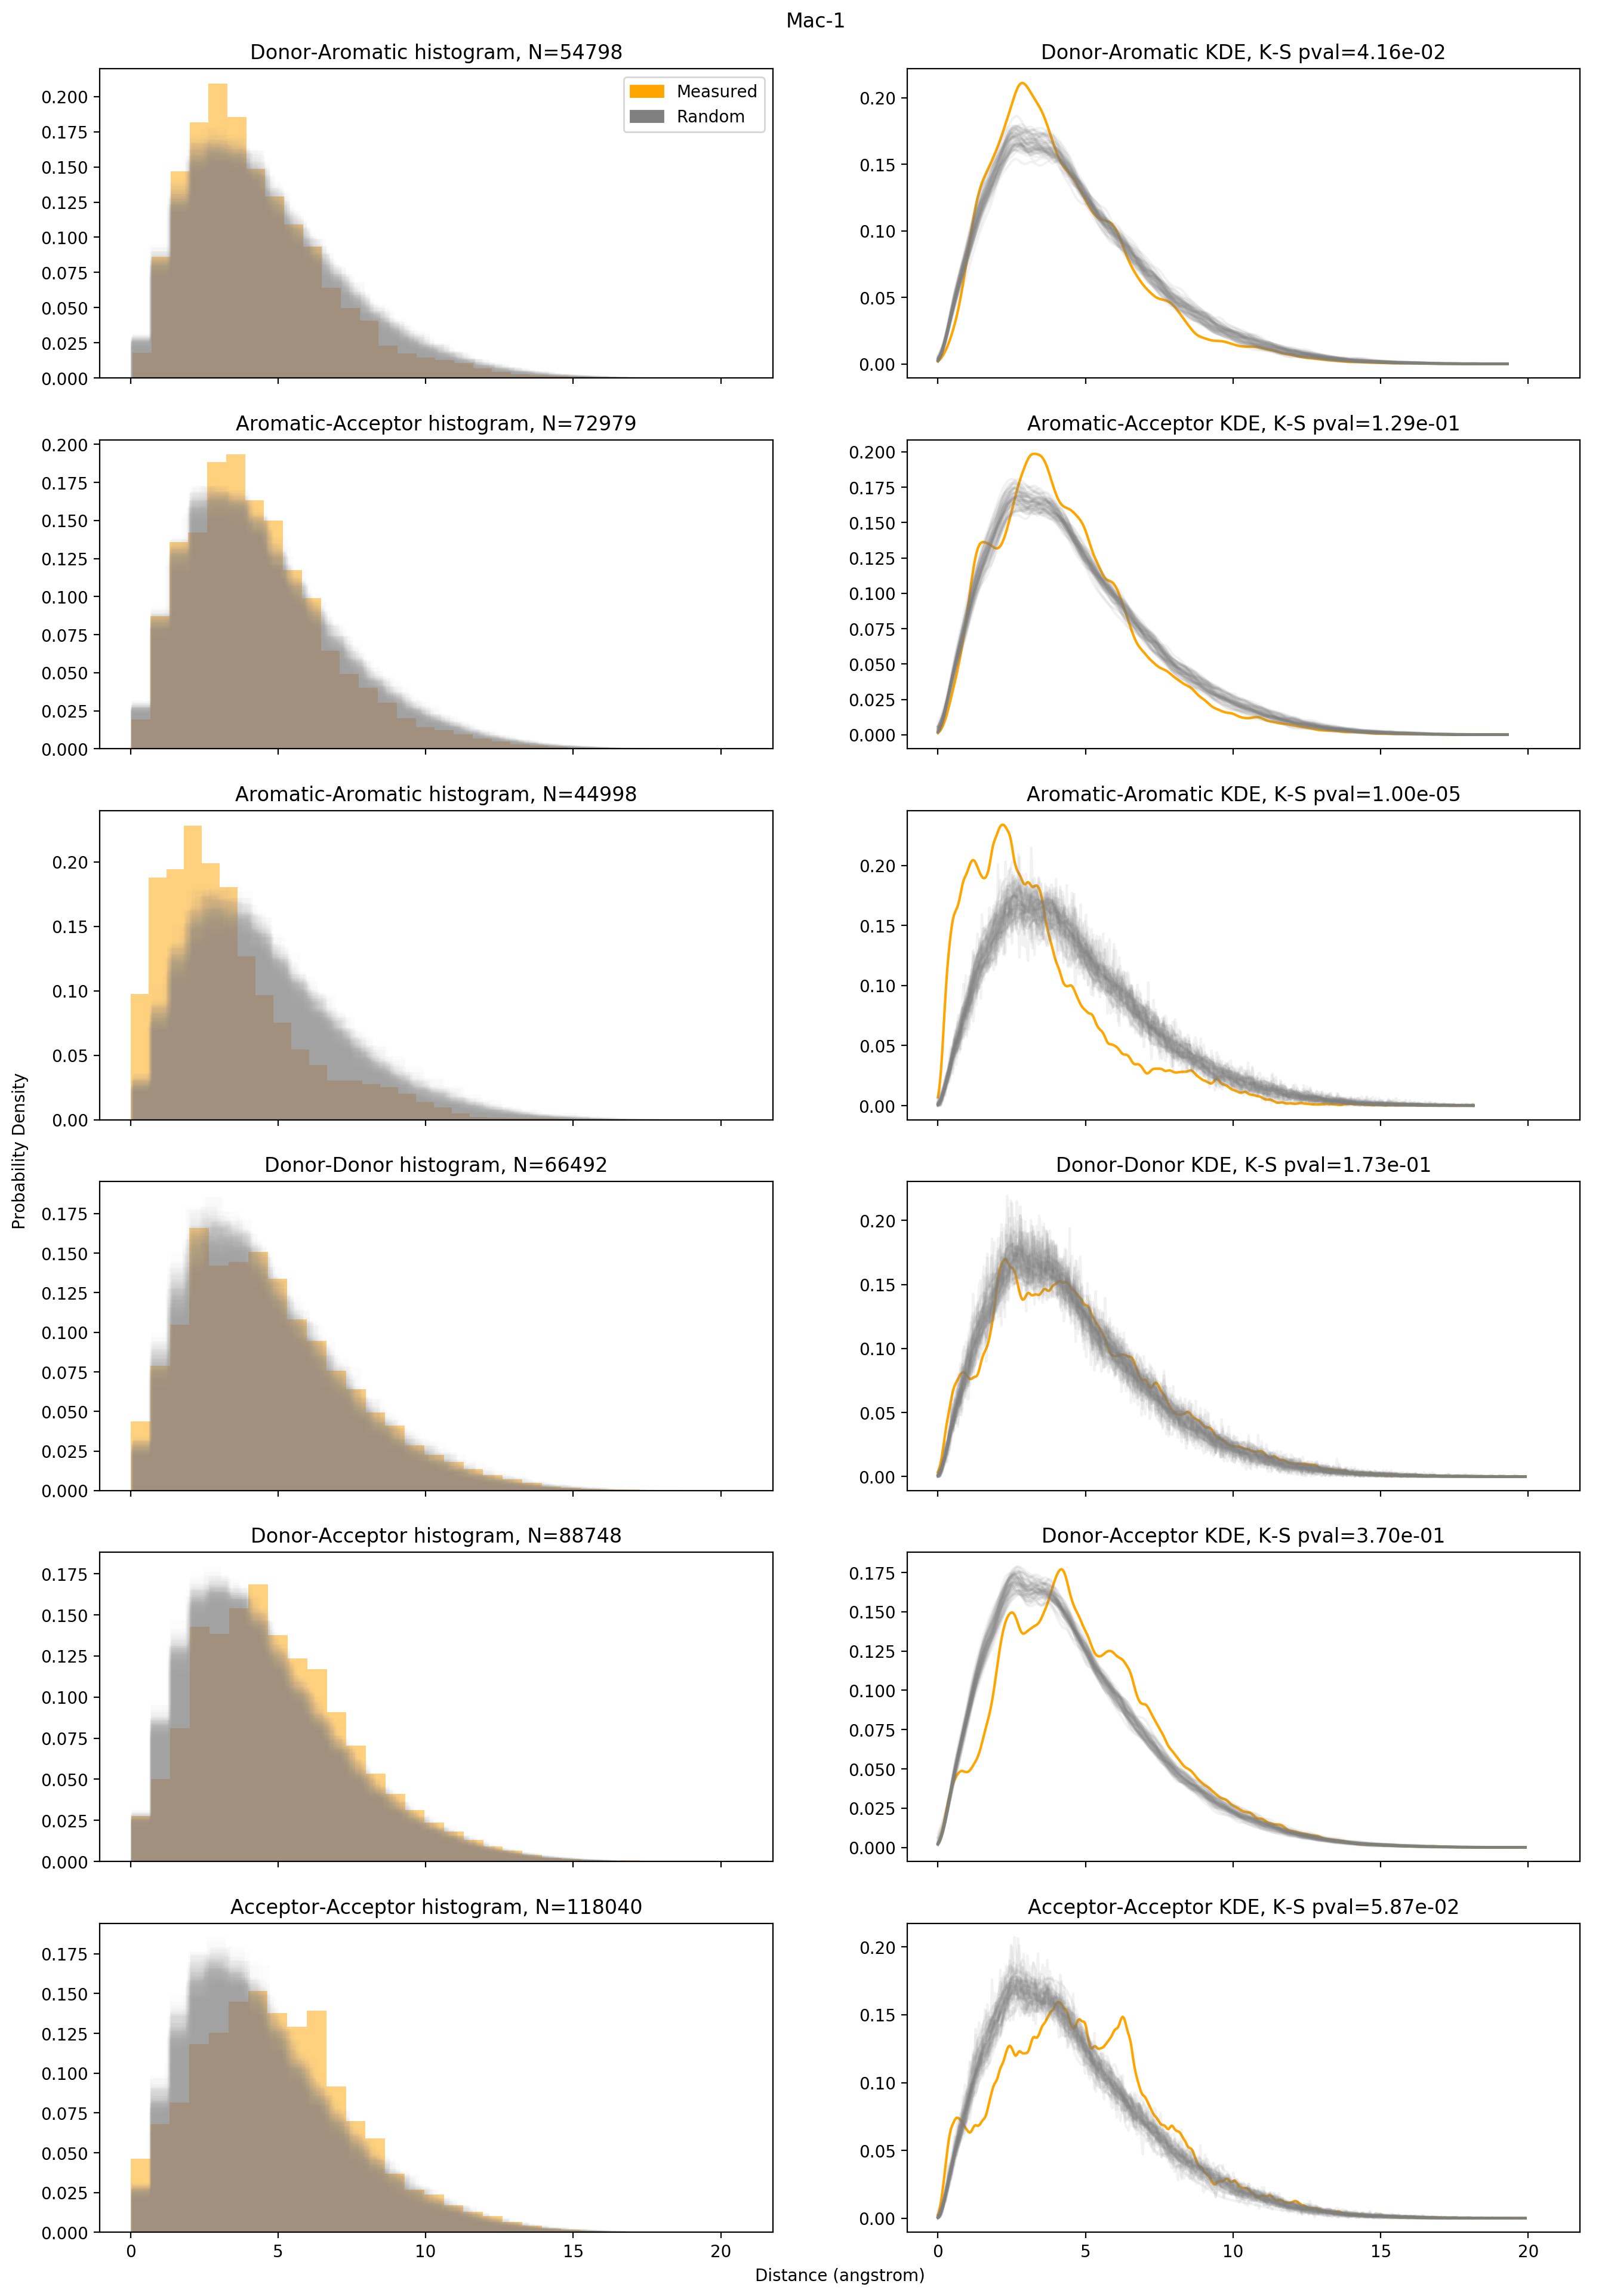

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

n_bins = 30
n_rand = 50
nx = 500

# mpl.rcParams['figure.dpi'] = 200

fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True, figsize=(16,24), dpi=200)
fig.suptitle('Mac-1', y=0.9)

for i, combo in tqdm(enumerate(pairs), total=6):
    axs[i,0].set_title('{} histogram, N={}'.format(combo, len(frag_pair_distance_dict[combo])))
    axs[i,0].hist(frag_pair_distance_dict[combo], bins=n_bins, alpha = 0.5, density=True, color='orange')
    
    axs[i,1].set_title('{} KDE, K-S pval={:.2e}'.format(combo, pvals[i]))
        
    kde_pair = kde_dict_opt[combo]
    
    x = np.linspace(0, np.amax(frag_pair_distance_dict[combo]), nx)
    
    pair_dist = np.exp(kde_pair.score_samples(x.reshape(-1,1)))
    pair_dist = pair_dist.flatten()
    pair_dist = pair_dist#/np.sum(pair_dist)
    
    axs[i,1].plot(x, pair_dist, color='orange')
    
    for n in range(n_rand):
        axs[i,0].hist(rand_pair_dicts[n][combo], bins=30, alpha=0.02, density=True, color='grey')
        
        kde_rand = rand_kde_dicts[n][combo]
    
        rand_dist = np.exp(kde_rand.score_samples(x.reshape(-1,1)))
        rand_dist = rand_dist.flatten()
        rand_dist = rand_dist#/np.sum(rand_dist)
        
        axs[i,1].plot(x, rand_dist, alpha=0.1, color='grey')
        
legend_elements = [Rectangle((0,0), 1,1 , color='orange', label='Measured'),
               Rectangle((0,0), 1,1,  color='grey', label='Random')]
axs[0,0].legend(handles=legend_elements, loc='upper right')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Distance (angstrom)')
plt.ylabel('Probability Density', labelpad=20)
fig.show()

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 6/6 [00:55<00:00,  9.26s/it]


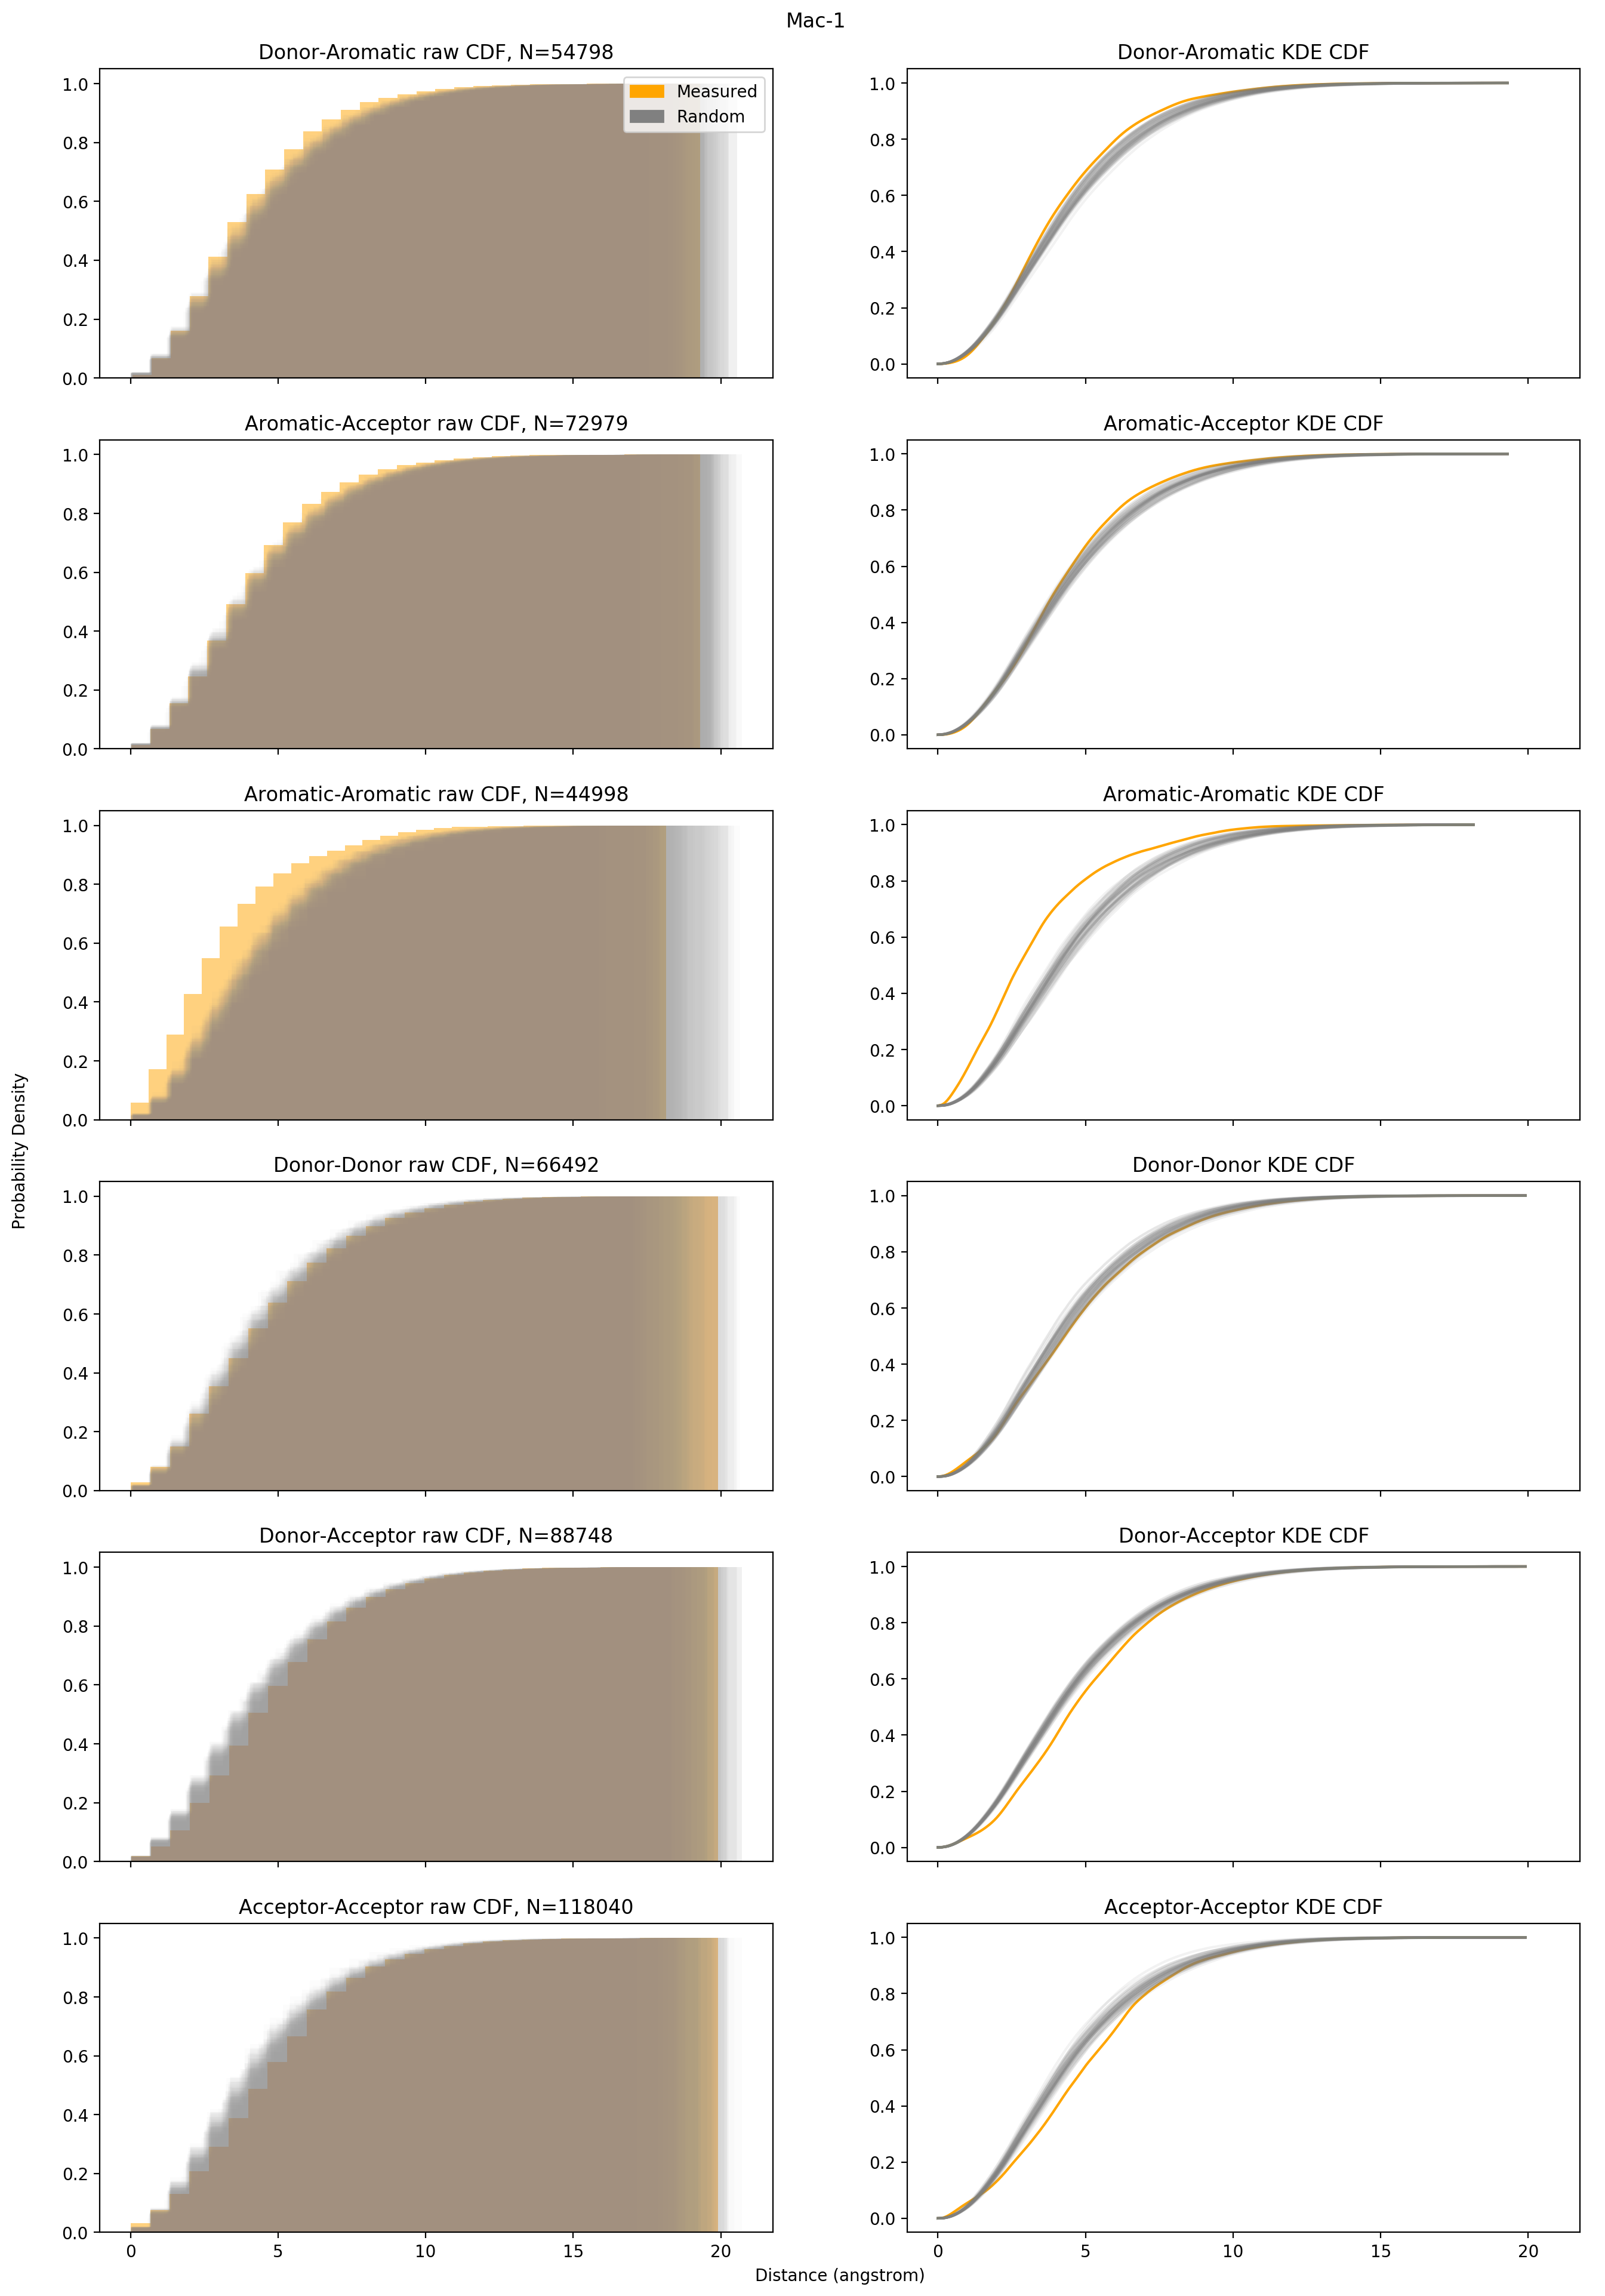

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

n_bins = 30
n_rand = 50
nx = 500

# mpl.rcParams['figure.dpi'] = 200

fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True, figsize=(16,24), dpi=200)
fig.suptitle('Mac-1', y=0.9)

for i, combo in tqdm(enumerate(pairs), total=6):
    axs[i,0].set_title('{} raw CDF, N={}'.format(combo, len(frag_pair_distance_dict[combo])))
    axs[i,0].hist(frag_pair_distance_dict[combo], bins=n_bins, alpha = 0.5, density=True, color='orange', cumulative=True)
    
    axs[i,1].set_title('{} KDE CDF'.format(combo))
        
    kde_pair = kde_dict_opt[combo]
    
    x = np.linspace(0, np.amax(frag_pair_distance_dict[combo]), nx)
    
    pair_dist = np.exp(kde_pair.score_samples(x.reshape(-1,1)))
    pair_dist = pair_dist.flatten()
    pair_dist = pair_dist#/np.sum(pair_dist)
    
    axs[i,1].plot(x, np.cumsum(pair_dist/np.sum(pair_dist)), color='orange')
    
    for n in range(n_rand):
        axs[i,0].hist(rand_pair_dicts[n][combo], bins=30, alpha=0.02, density=True, color='grey', cumulative=True)
        
        kde_rand = rand_kde_dicts[n][combo]
    
        rand_dist = np.exp(kde_rand.score_samples(x.reshape(-1,1)))
        rand_dist = rand_dist.flatten()
        rand_dist = rand_dist#/np.sum(rand_dist)
        
        axs[i,1].plot(x, np.cumsum(rand_dist/np.sum(rand_dist)), alpha=0.1, color='grey')
        
legend_elements = [Rectangle((0,0), 1,1 , color='orange', label='Measured'),
               Rectangle((0,0), 1,1,  color='grey', label='Random')]
axs[0,0].legend(handles=legend_elements, loc='upper right')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Distance (angstrom)')
plt.ylabel('Probability Density', labelpad=20)
fig.show()